In [200]:
# --- Project Setup ---
from setup_notebook import setup_project_root
setup_project_root()

# --- Imports ---
from src.project_config import N_OUT_PROTEIN_ID, COLORS_MODELS, COLORS_SECONDARY, PROCESSED_DIR, PROTEIN_IDS_CSV, IMAGES_DIR, get_paths_protein, get_paths
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm


### Data processing
   1. load rank statistics data
   2. average over tmd+jmd + TMD + cleavage site + anker 
   3. 

In [62]:
n_out_protein_ids = pd.read_csv(N_OUT_PROTEIN_ID)

In [63]:
# 1. Load N-Out protein IDs, load fom DSSP_ALL_HUMAN_PROTEOME proteins statistics CSV
store_data = n_out_protein_ids.copy()
protein_averages = []
count_fails = 0

for protein_id in tqdm(store_data["entry"], desc="Processing Proteins"):  # for testing ["P05067", "Q06418"]: 
    # Load protein statistics
    try:
        protein_statistics = pd.read_csv(get_paths_protein(protein_id)["dssp_protein_path"])
    except FileNotFoundError:
        print(f"File not found for protein {protein_id}. Skipping...")
        count_fails += 1
        continue




    # Mean overall
    AM_overall_mean = round(protein_statistics["AM_mean"].mean(), 6)
    ESM_overall_mean = round(protein_statistics["ESM_mean"].mean(), 6)
    protein_averages.append((store_data.loc[store_data["entry"] == protein_id]["length"].iloc[0], AM_overall_mean, ESM_overall_mean))
    store_data.loc[store_data["entry"] == protein_id, "AM_Protein_Mean"] = AM_overall_mean
    store_data.loc[store_data["entry"] == protein_id, "ESM_Protein_Mean"] = ESM_overall_mean





    ### Mean over TMD+JMD and assign to store_data ###
    AM_TMD_JMD_mean = round(protein_statistics[
        (protein_statistics["Transmembrane"] == "Helical") | 
        (protein_statistics["Juxtamembrane"] == 1)
    ]["AM_mean"].mean(), 6)

    ESM_TMD_JMD_mean = round(protein_statistics[
        (protein_statistics["Transmembrane"] == "Helical") | 
        (protein_statistics["Juxtamembrane"] == 1)
    ]["ESM_mean"].mean(), 6)

    store_data.loc[store_data["entry"] == protein_id, "AM_TMD_JMD_mean"] = AM_TMD_JMD_mean
    store_data.loc[store_data["entry"] == protein_id, "ESM_TMD_JMD_mean"] = ESM_TMD_JMD_mean
    ### ###




    ### Mean over cleavage_site and TMD-C anchor ###
    # 11AA Cleavage Region (TMD-C 7, JMD 4) - start end
    row = store_data.loc[store_data['entry'] == protein_id].squeeze()
    highlight_start = row['len_signal_pep'] + row['len_top_n'] + row['len_tmd']  - 6
    highlight_end = row['len_signal_pep'] + row['len_top_n'] + row['len_tmd']  + 4

    AM_cleavage_11AA_mean = round(protein_statistics[
        (protein_statistics["residue_position"] >= highlight_start) &
        (protein_statistics["residue_position"] <= highlight_end)
    ]["AM_mean"].mean(), 6)

    ESM_cleavage_11AA_mean = round(protein_statistics[
        (protein_statistics["residue_position"] >= highlight_start) &
        (protein_statistics["residue_position"] <= highlight_end)
    ]["ESM_mean"].mean(), 6)

    store_data.loc[store_data["entry"] == protein_id, "AM_cleavage_11AA_mean"] = AM_cleavage_11AA_mean
    store_data.loc[store_data["entry"] == protein_id, "ESM_cleavage_11AA_mean"] = ESM_cleavage_11AA_mean
    ### ###




# Extract weights, second numbers, and third numbers
weights = np.array([t[0] for t in protein_averages], dtype=np.float64)
am_numbers = np.array([t[1] for t in protein_averages], dtype=np.float64)
esm_numbers = np.array([t[2] for t in protein_averages], dtype=np.float64)

# Compute weighted means
weighted_mean_am = np.sum(weights * am_numbers) / np.sum(weights)
weighted_mean_esm = np.sum(weights * esm_numbers) / np.sum(weights)

# Print results
print(f"Weighted mean (AM): {weighted_mean_am}")
print(f"Weighted mean (ESM)): {weighted_mean_esm}")

print(f"Number of failed protein statistics files: {count_fails}")


Processing Proteins:   0%|          | 0/1534 [00:00<?, ?it/s]

File not found for protein Q8N423. Skipping...
File not found for protein Q9HDB5. Skipping...
File not found for protein P58400. Skipping...
File not found for protein P58401. Skipping...
File not found for protein P0DSE2. Skipping...
File not found for protein P23467. Skipping...
File not found for protein Q9H195. Skipping...
File not found for protein Q8NAU1. Skipping...
File not found for protein O42043. Skipping...
File not found for protein Q92813. Skipping...
File not found for protein P49895. Skipping...
File not found for protein A8MZ97. Skipping...
File not found for protein O71037. Skipping...
File not found for protein P61566. Skipping...
File not found for protein Q69384. Skipping...
File not found for protein P61567. Skipping...
File not found for protein Q902F8. Skipping...
File not found for protein Q9UKH3. Skipping...
File not found for protein Q9BQE4. Skipping...
File not found for protein Q16850. Skipping...
File not found for protein Q8TD46. Skipping...
File not foun

In [64]:
store_data.head(15)
from pathlib import Path

# Ensure the directory exists
output_path = PROCESSED_DIR / "1.1.Experiment_TMD_JMD" / "1.1.TMD_JMD_Cleavage_Site_Experiment.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)

# Save the file
store_data.to_csv(output_path, index=False)

### Plotting


In [75]:
data_to_plot = store_data.copy()


# Remove rows where "ESM_cleavage_11AA_mean" is NaN
data_to_plot = data_to_plot.dropna(subset=["ESM_cleavage_11AA_mean"])
data_to_plot.describe()

,PRED_MEAN [%],PRED_STD [%],new_hc_substrate,human_n-out_proteome,length,len_signal_pep,len_top_n,len_tmd,len_top_c,len_tmd_AN,AM_Protein_Mean,ESM_Protein_Mean,AM_TMD_JMD_mean,ESM_TMD_JMD_mean,AM_cleavage_11AA_mean,ESM_cleavage_11AA_mean
count,1502.000000,1502.000000,1502.000000,1502.0,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1496.000000,1496.000000,1502.000000,1502.000000
mean,53.809874,14.036318,0.105859,1.0,677.364847,19.609854,472.215712,21.334887,164.204394,21.340213,0.465984,0.469870,0.488874,0.510201,0.515673,0.534470
std,22.515604,5.753651,0.307759,0.0,700.074751,12.738004,668.474798,1.718061,193.317036,1.698287,0.084408,0.128913,0.143260,0.176982,0.157192,0.192391
min,9.710000,1.450000,0.000000,1.0,51.000000,0.000000,1.000000,16.000000,6.000000,16.000000,0.270088,0.135218,0.168845,0.121378,0.174327,0.110836
25%,34.360000,9.950000,0.000000,1.0,289.000000,16.000000,132.000000,21.000000,39.000000,21.000000,0.399671,0.387081,0.378895,0.360930,0.392077,0.376850
50%,53.950000,14.390000,0.000000,1.0,525.000000,22.000000,316.500000,21.000000,85.000000,21.000000,0.449226,0.481251,0.463452,0.512658,0.497641,0.542790
75%,72.685000,18.167500,0.000000,1.0,868.500000,27.000000,641.500000,21.000000,219.000000,21.000000,0.524814,0.566842,0.590499,0.660639,0.626587,0.700100
max,95.220000,31.200000,1.000000,1.0,14507.000000,89.000000,14451.000000,41.000000,1717.000000,41.000000,0.770099,0.763258,0.870502,0.870710,0.919491,0.882336


In [76]:
# --- Imports ---
from src.project_config import COLORS_MODELS, PROCESSED_DIR, PROTEIN_IDS_CSV, get_paths_protein, get_paths
from __future__ import unicode_literals
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import importlib
import matplotlib.patheffects as path_effects



# For Statistics
import statsmodels.api as sm
from scipy.stats import normaltest, skew, kurtosis, anderson, levene, kruskal
import scikit_posthocs as sp



import src.utils as utils

# Reload the module to reflect the latest changes or RESTART the KERNEL
importlib.reload(utils)

# Now you should see the updated functions
print(dir(utils))

# Set plotting style
plt.style.use('seaborn-v0_8-white')  # Corrected style
sns.set_style("whitegrid")  # Use sns to set a Seaborn style
FONTSIZE="xx-large"
COLORS = cm.viridis(np.linspace(0.4, 1, 7))



['Path', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'compute_highlight_regions', 'get_project_paths', 'group_by_pred_class', 'load_dotenv', 'os', 'pd', 'save_csv_no_overwrite']


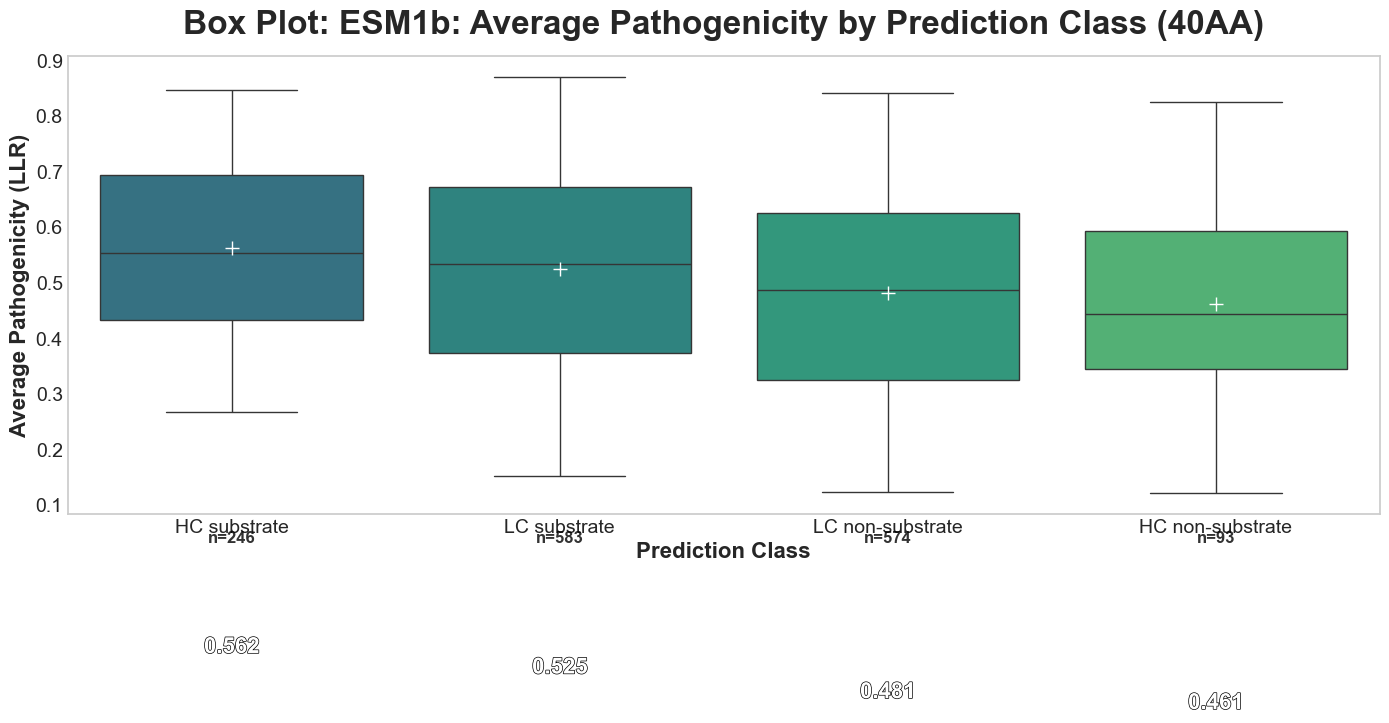

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from scipy.stats import mannwhitneyu



def plot_model_boxplot(data, y_column, model, global_mean=None, save=False):
    assert model in ["ESM", "AlphaMissense"], "Model must be 'ESM' or 'AlphaMissense'"
    
    model_key = "ESM" if model == "ESM" else "AM"
    base_color = COLORS_MODELS[model_key]
    

    # Generate 4 monochromatic shades from base color
    base_rgb = mcolors.to_rgb(base_color)
    monochrome_colors = [mcolors.to_hex([base_rgb[0]*(1-0.2*i), base_rgb[1]*(1-0.2*i), base_rgb[2]*(1-0.2*i)]) for i in range(4)]

    # Ensure pred_class is ordered correctly
    category_order = ["HC substrate", "LC substrate", "LC non-substrate", "HC non-substrate"]
    data['pred_class'] = pd.Categorical(data['pred_class'], categories=category_order, ordered=True)

    plt.figure(figsize=(8,6))
    sns.set_style("whitegrid")
    
    ax = sns.boxplot(
        x="pred_class", 
        y=y_column, 
        data=data,
        palette=monochrome_colors,
        showfliers=False,
        width=0.6
    )

    # Overlay the mean as a black diamond marker
    means = data.groupby('pred_class')[y_column].mean().reindex(category_order)
    sns.scatterplot(
        x=category_order,
        y=means.values,
        color='white',
        marker='D',
        s=80,
        zorder=5,
        ax=ax
    )

    # Add numeric labels above mean diamonds
    for i, mean_val in enumerate(means):
        ax.text(
            i -0.075,  # slight horizontal offset to the right of diamond
            mean_val,  # slight vertical offset above diamond
            f'{mean_val:.3f}',
            ha='right',
            va='center',
            fontsize=11,
            color='white',
            fontweight='bold'
        )



    # Add data counts below boxplots
    group_counts = data.groupby('pred_class')[y_column].count().reindex(category_order)
    for i, count in enumerate(group_counts):
        ax.text(
            i, 0 if model == "ESM" else 0.075,  # Adjusted position for ESM and AlphaMissense
            f'n={count}',
            ha='center',
            va='bottom',
            fontsize=10,
            color='black',
            alpha=0.8,
        )

    
    
    # Plot the overall mean as a horizontal line with label for legend
    ax.axhline(
        y=0.4765 if model == "AlphaMissense" else 0.505,  # Adjusted for AlphaMissense
        color='#d5c7f7',
        linestyle='--', 
        linewidth=2,
        alpha=0.7,
        zorder=3,
        label=f'Pathogenicity Mean of N-out Proteome = {0.4765 if model == "AlphaMissense" else 0.505:.3f} ({"AM" if model == "AlphaMissense" else "ESM"})'
    )



    # Perform Mann-Whitney U Test between "HC Substrate" and "HC Non-Substrate"
    group1 = data[data['pred_class'] == 'HC substrate'][y_column]
    group2 = data[data['pred_class'] == 'HC non-substrate'][y_column]

    # Perform the test (two-sided)
    _, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    print(p_value)
    if p_value < 0.05:
        # Find the x positions of the boxes (based on your category order)
        x1 = category_order.index('HC substrate')
        x2 = category_order.index('HC non-substrate')

        # Determine y-position for annotation line (a bit above the max y of both groups)
        y_max1 = group1.max()
        y_max2 = group2.max()
        y, h, col = max(y_max1, y_max2) + 0.05, 0.02, 'red'  # h is the line height offset

        # Plot the connecting line
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color=col)

        # Annotate the p-value above the line
        ax.text(
            (x1 + x2) / 2, 
            y + h + 0.01,  # a bit above the line
            f'p = {p_value:.3e}', 
            ha='center', 
            va='bottom',
            color=col,
            fontsize=12,
            fontweight='bold'
        )

    # Aesthetics
    ax.set_xlabel("Prediction Class", fontsize=12, fontweight='bold')
    ax.set_ylabel("Average Rank Pathogenicity Score", fontsize=12, fontweight='bold')

    if y_column == "AM_TMD_JMD_mean" or y_column == "ESM_TMD_JMD_mean":
        title = "TMD + JMD-N/C Region (~40AA)"
    elif y_column == "AM_cleavage_11AA_mean" or y_column == "ESM_cleavage_11AA_mean":
        title = "Cleavage Site Region (11AA)"

    ax.set_title(f"{title} ({model})", fontsize=14, pad=15)
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10)
    # Place the legend to show the global mean
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False, fontsize=12)
    sns.despine()
    plt.tight_layout()


    # Save plot
    if save:
        images_path = IMAGES_DIR / "1.1.Boxplots"
        images_path.mkdir(parents=True, exist_ok=True)
        output_path = images_path / f"1.1.{y_column}_.png" 
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_path}")

    plt.show()
    print(p_value)
# Usage Example:
# plot_model_boxplot(store_data.copy(), y_column="mean_score", model="ESM")


1.4304622389777605e-05
Plot saved to /Users/doma/Documents/Bachelor_Arbeit/Code/results/images/1.1.Boxplots/1.1.ESM_TMD_JMD_mean_.png


/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_80565/2989081683.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_80565/2989081683.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = data.groupby('pred_class')[y_column].mean().reindex(category_order)
/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_80565/2989081683.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

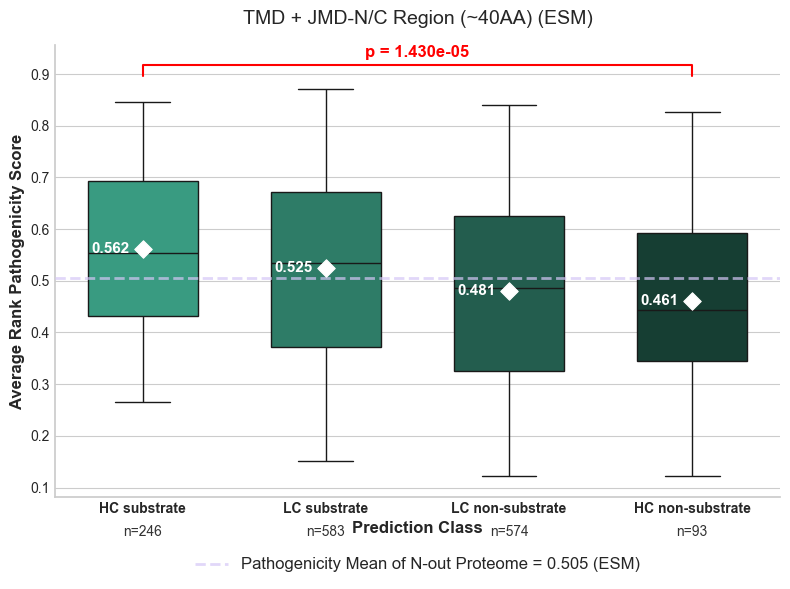

1.4304622389777605e-05


In [279]:
data_to_plot = store_data.copy()


# Remove rows where "ESM_cleavage_11AA_mean" is NaN
data_to_plot = data_to_plot.dropna(subset=["ESM_cleavage_11AA_mean", "ESM_TMD_JMD_mean"])

plot_model_boxplot(data_to_plot.copy(), y_column="ESM_TMD_JMD_mean", model="ESM", global_mean=True, save=True)


In [277]:
#Weighted mean (second numbers): 0.47649107164228105
#Weighted mean (third numbers): 0.5048395241723528